In [10]:
from zpmeta.funcs.func import Func 
from pandas import DataFrame
import pandas as pd
from dateutil.relativedelta import relativedelta
import os

In [39]:

class Cumulate_g_Returns(Func):
    """Function class for calculating the cumulative return from daily returns.
    """
    @classmethod
    def _std_params(cls, name=None):
        params = dict(freq='M', extrapolate=True)
        return params
    
    @classmethod
    def _execute(cls, operand: DataFrame=None, params: dict = None) -> object:
        if params['extrapolate']:
            df = DataFrame(0, index=[operand.index[-1] + relativedelta(years=1)], columns=operand.columns)
            freq_returns = operand.combine_first(df)
        cumulative_returns = (1.0 + freq_returns).cumprod(skipna=True).fillna(method='pad').asfreq(params['freq'], method='pad')
        if params['extrapolate']:
            next_period_date = cumulative_returns.index[cumulative_returns.index>=operand.index[-1]][0] # immediate next period date
            cumulative_returns = cumulative_returns.truncate(after=next_period_date) # truncate after next period date
        
        prev_returns = cumulative_returns.shift(1).fillna(1.0)
        result = (cumulative_returns/prev_returns).dropna(how='all') - 1.0
        
        return result

In [60]:
class Drawdowns_g_R(Func):
    """Calculate rolling drawdowns given returns.
    """
    @classmethod
    def _std_params(cls, name=None):
        params = dict(freq='M', type=['flat'])
        return params

    @classmethod
    def _execute(cls, operand=None, params: dict = None) -> DataFrame:
        freq_returns = Cumulate_g_Returns({'freq': params['freq'], 'extrapolate': True})(operand)
        
        freq_index = (1.0 + freq_returns).cumprod()
        expanding_max_index = freq_index.expanding().max()
        drawdown = -1.0 * ((expanding_max_index - freq_index) / expanding_max_index).applymap(lambda x: x if x > 0 else 0)
        
        # results = DataFrame()
        # for type in params['types']:
        #     if type == 'flat':
        #         dd = drawdown
        #     if type == 'avg':
        #         dd = drawdown.expanding().mean()
        #     elif type == 'max':
        #         dd = drawdown.expanding().max()
        #     
        #     # if the columns of dd are MultiIndex, add the 'type' as the second level of the MultiIndex
        #     if isinstance(dd.columns, pd.MultiIndex):
        #         dd.columns = dd.columns.set_levels([type], level=1)
        #     else:
        #         dd.columns = [type]
        #     
        #     
        #     # join dd to the results with 'type' in a MultiIndex column with name as the value in 'type'
        #     results = results.join(dd, how='outer', rsuffix='_' + type)
             
        return drawdown
    
class AverageDrawdowns_g_R(Func):
    """Calculate the average drawdown given returns.
    """
    @classmethod
    def _std_params(cls, name=None):
        params = dict(freq='M')
        return params

    @classmethod
    def _execute(cls, operand=None, params: dict = None) -> DataFrame:
        drawdown = Drawdowns_g_R(params)(operand)
        
        # calculate rolling average of the drawdown
        avg_drawdown = drawdown.expanding().mean()
        
        return avg_drawdown
    
class MaxDrawdowns_g_R(Func):
    """Calculate the maximum drawdown given returns.
    """
    @classmethod
    def _std_params(cls, name=None):
        params = dict(freq='M')
        return params

    @classmethod
    def _execute(cls, operand=None, params: dict = None) -> DataFrame:
        drawdown = Drawdowns_g_R(params)(operand)
        
        # calculate rolling average of the drawdown
        max_drawdown = drawdown.expanding().max()
        
        return max_drawdown
    
class LongestDrawdownPeriods_g_R(Func):
    """Calculate the longest N drawdown periods given returns.
    """
    @classmethod
    def _std_params(cls, name=None):
        params = dict(freq='M', num_periods=5)
        return params
    
    @classmethod
    def _execute(cls, operand=None, params: dict = None) -> DataFrame:
        drawdowns = Drawdowns_g_R(params)(operand)

        def find_longest_drawdown_periods_for_column(drawdown_series, num_periods):
            in_drawdown = False
            drawdown_periods = []
        
            for i in range(len(drawdown_series)):
                if drawdown_series.iloc[i] < 0:
                    if not in_drawdown:
                        in_drawdown = True
                        start_date = drawdown_series.index[i]
                        max_drawdown = drawdown_series.iloc[i]
                        max_drawdown_date = drawdown_series.index[i]
                    else:
                        if drawdown_series.iloc[i] < max_drawdown:
                            max_drawdown = drawdown_series.iloc[i]
                            max_drawdown_date = drawdown_series.index[i]
                else:
                    if in_drawdown:
                        end_date = drawdown_series.index[i - 1]
                        period_length = end_date - start_date
                        drawdown_periods.append((start_date, end_date, period_length, max_drawdown, max_drawdown_date))
                        in_drawdown = False
        
            if in_drawdown:
                end_date = drawdown_series.index[-1]
                period_length = end_date - start_date
                drawdown_periods.append((start_date, end_date, period_length, max_drawdown, max_drawdown_date))
        
            drawdown_df = pd.DataFrame(drawdown_periods, columns=['start_date', 'end_date', 'length', 'max_drawdown', 'max_drawdown_date'])
            drawdown_df = drawdown_df.sort_values(by='length', ascending=False)
            drawdown_df = drawdown_df.head(num_periods)
            drawdown_df.index = range(1, len(drawdown_df) + 1)
        
            return drawdown_df
        
        all_results = []
    
        for column in drawdowns.columns:
            result_df = find_longest_drawdown_periods_for_column(drawdowns[column], params['num_periods'])
            result_df.columns = pd.MultiIndex.from_product([[column], result_df.columns])
            all_results.append(result_df)
    
        combined_results = pd.concat(all_results, axis=1)

        return combined_results


In [67]:
worksp = r'C:\Users\raman\OneDrive\MSx\CMC\Convex'

# set the working directory to the location of the data files
os.chdir(worksp)

# read returns from the 'Daily' sheet of GETT_Portfolio_Returns_CSV.xlsx workbook
returns = pd.read_excel(os.path.join(worksp, 'GETT_Portfolio_Returns_Non.xlsx'), sheet_name='Daily', index_col=0, parse_dates=True)

# do some detailed EDA on the returns
returns.describe()
returns.info()

# returns = pd.read_csv(os.path.join(worksp, 'GETT_Portfolio_Returns_CSV.csv'), index_col=0, parse_dates=True)

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 5652 entries, 2002-01-02 to 2023-08-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   GETT    5652 non-null   float64
dtypes: float64(1)
memory usage: 88.3 KB


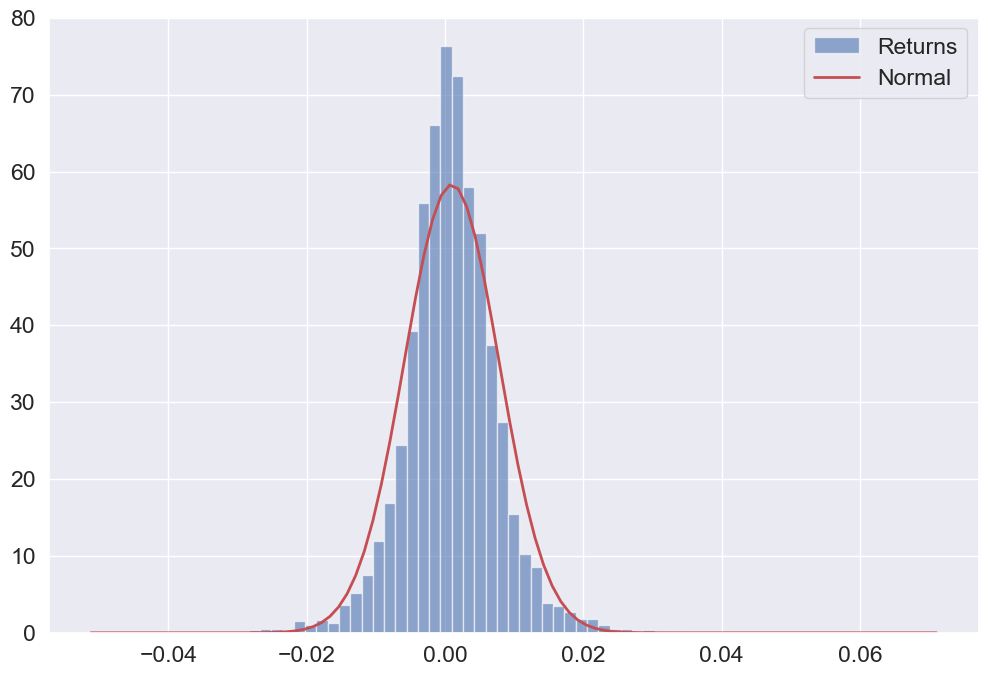

In [68]:


# plot a histogram of the returns and overlay with the standard normal distribution and add the mean, std, skew and kurtosis values as text somewhere in the plot
import matplotlib.pyplot as plt
import numpy as np
import scipy.stats as stats
import seaborn as sns

def hist_returns(returns, bins):
    sns.set_style('whitegrid')
    sns.set_context('talk')
    sns.set_palette('dark')
    sns.set(font_scale=1.5)
    plt.figure(figsize=(12, 8))
    plt.hist(returns, bins=75, density=True, alpha=0.6, label='Returns')
    x = np.linspace(returns.min(), returns.max(), 100)
    plt.plot(x, stats.norm.pdf(x, loc=returns.mean(), scale=returns.std()), 'r', lw=2, label='Normal')
    plt.legend()
    plt.show()
    
hist_returns(returns, 75)

# add the first four moments to the plot


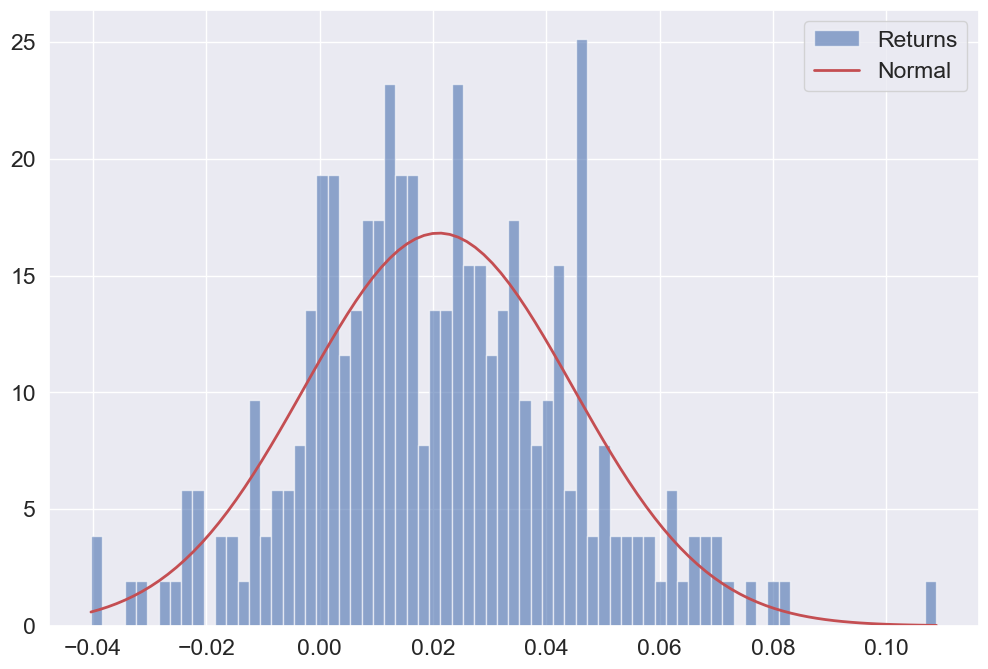

In [69]:
freq_ret = Cumulate_g_Returns({'freq': 'M', 'extrapolate': True})(returns)
freq_ret
hist_returns(freq_ret, 75)

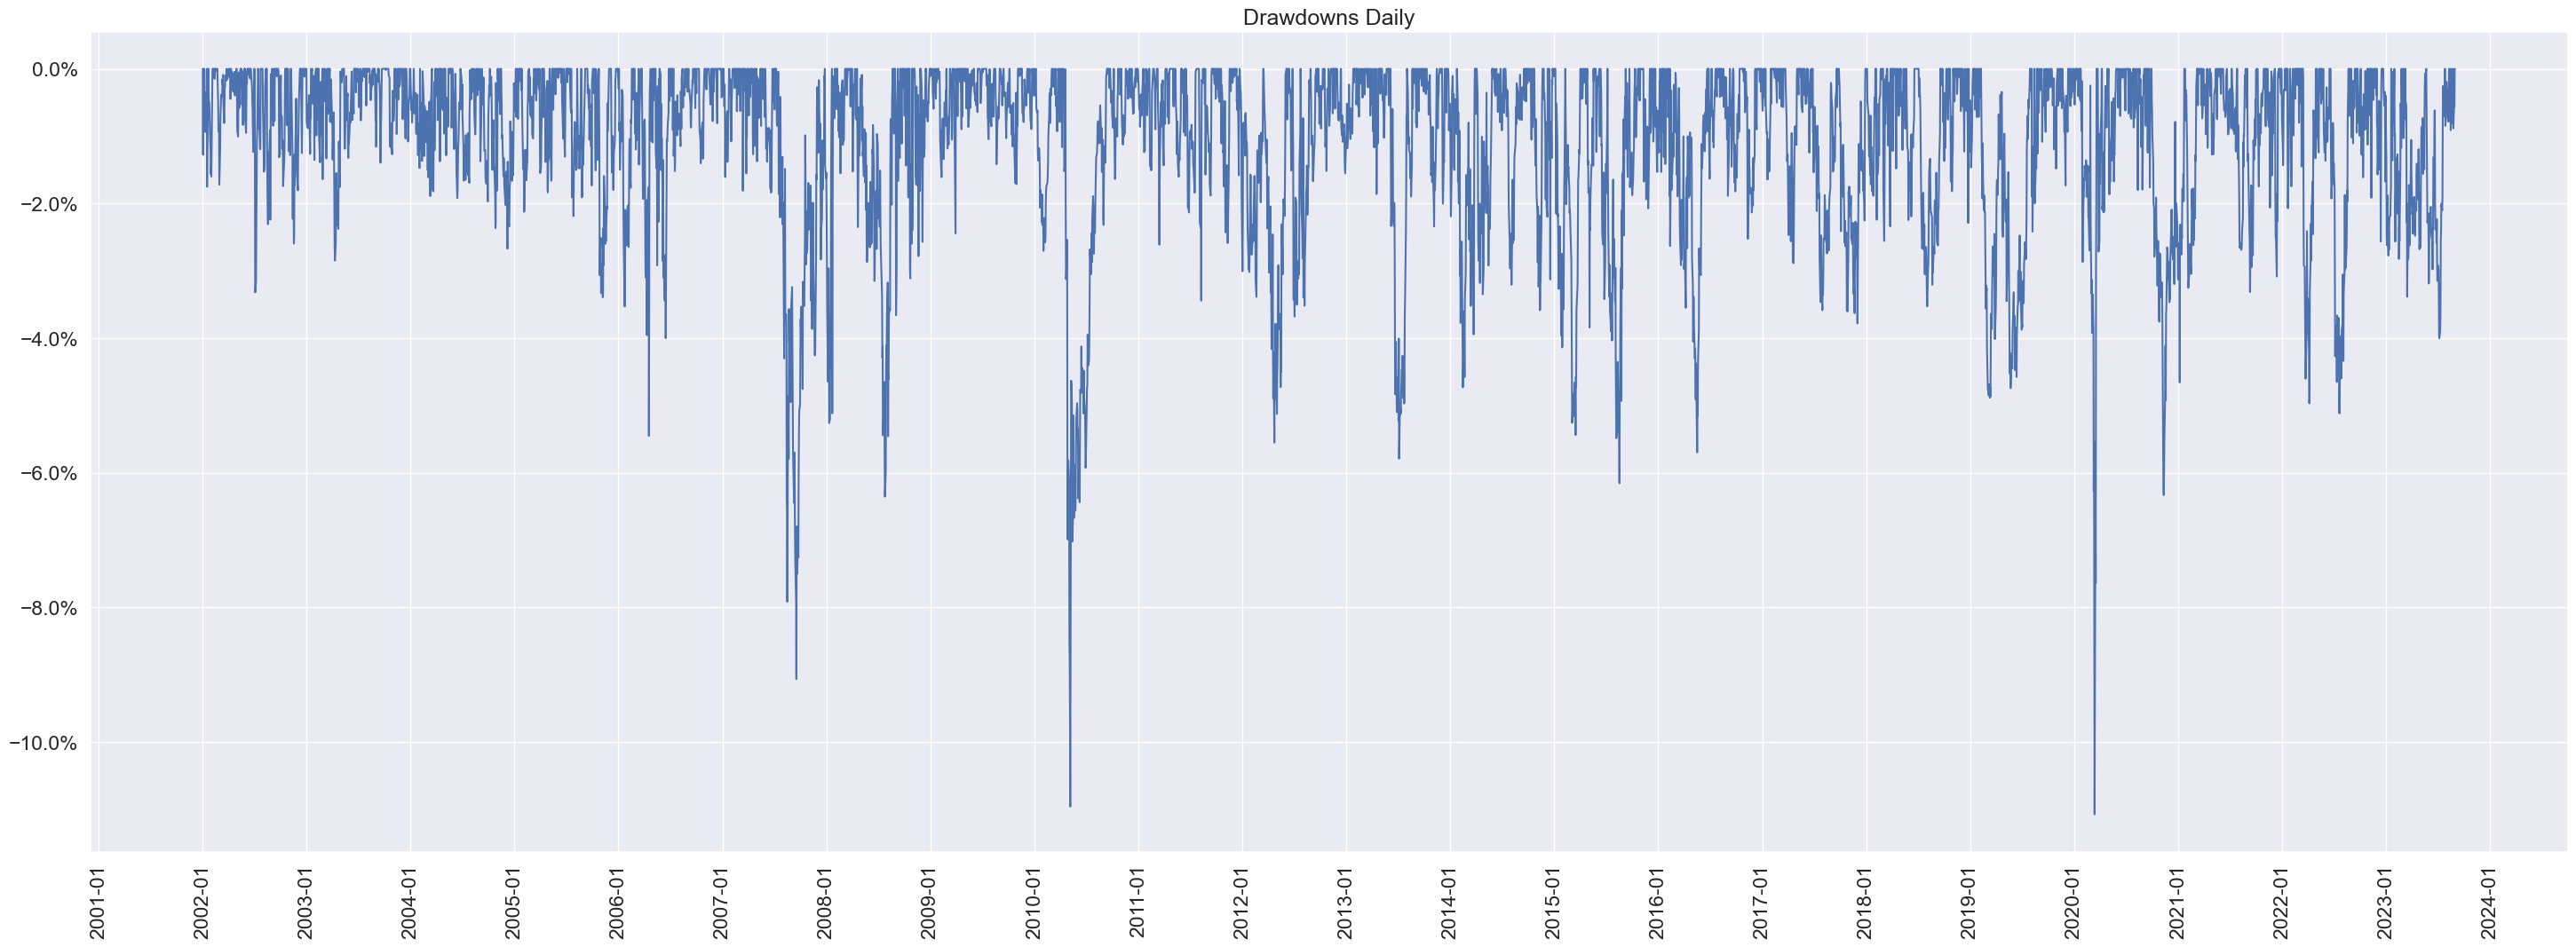

<Figure size 640x480 with 0 Axes>

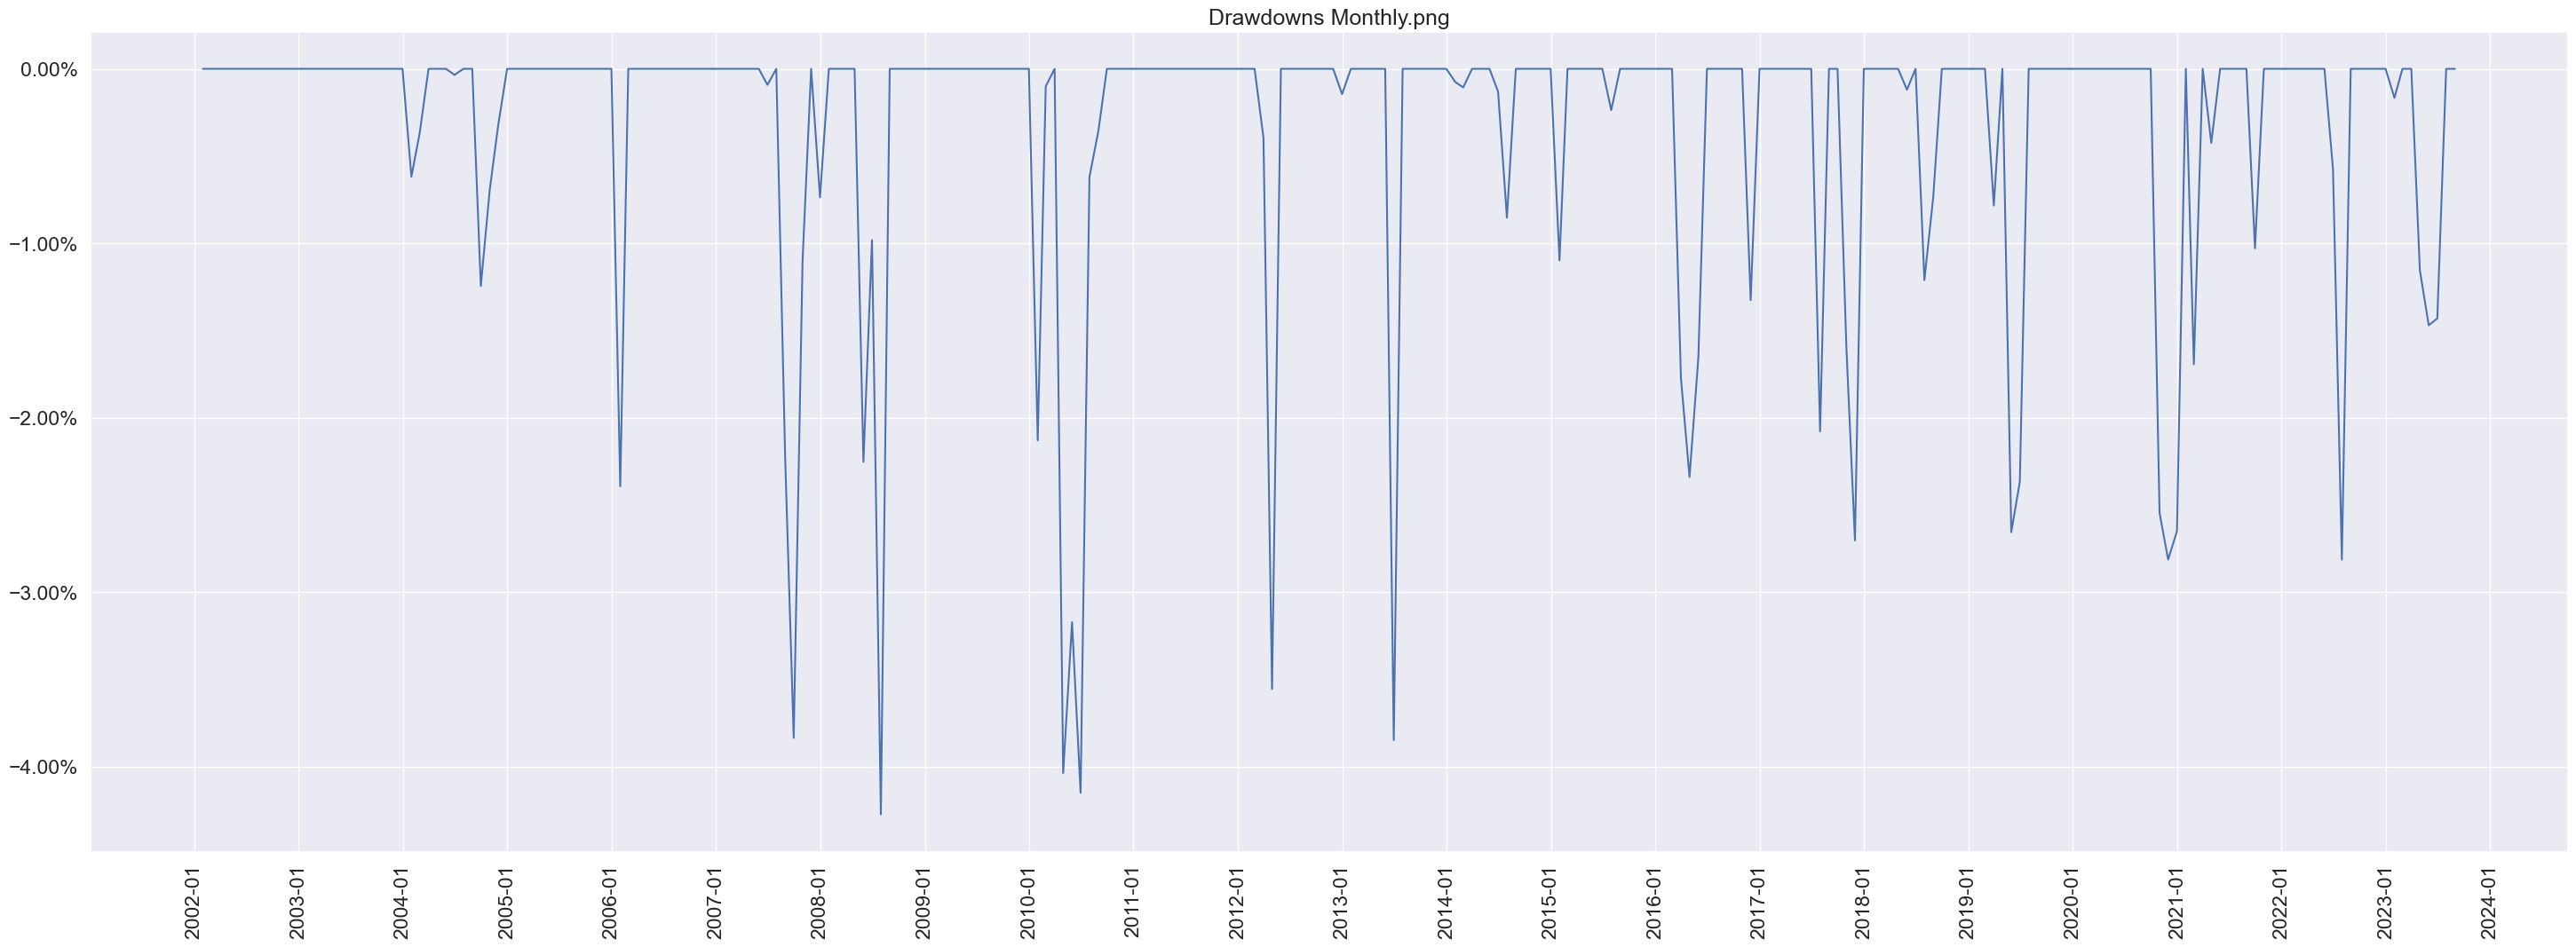

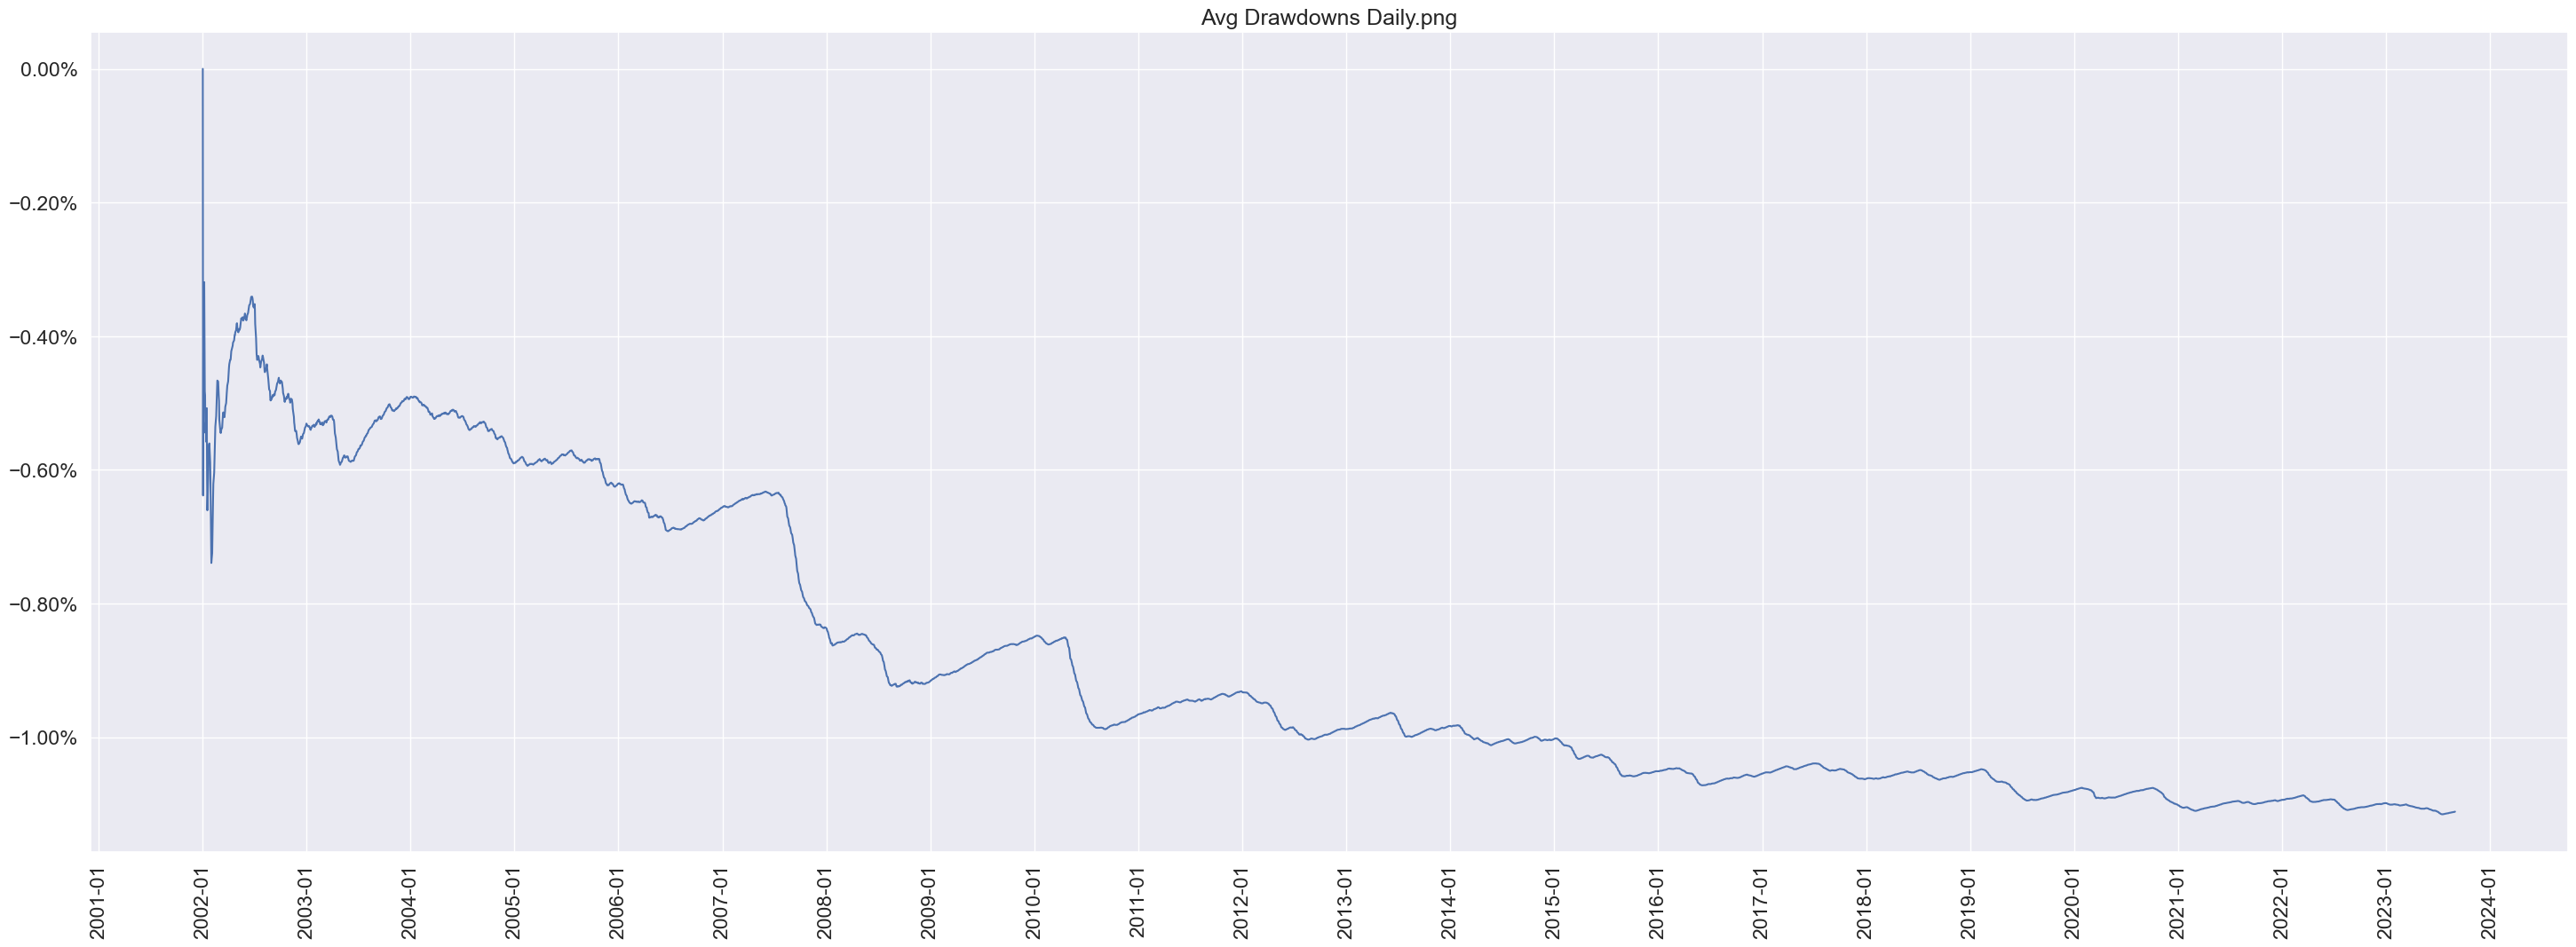

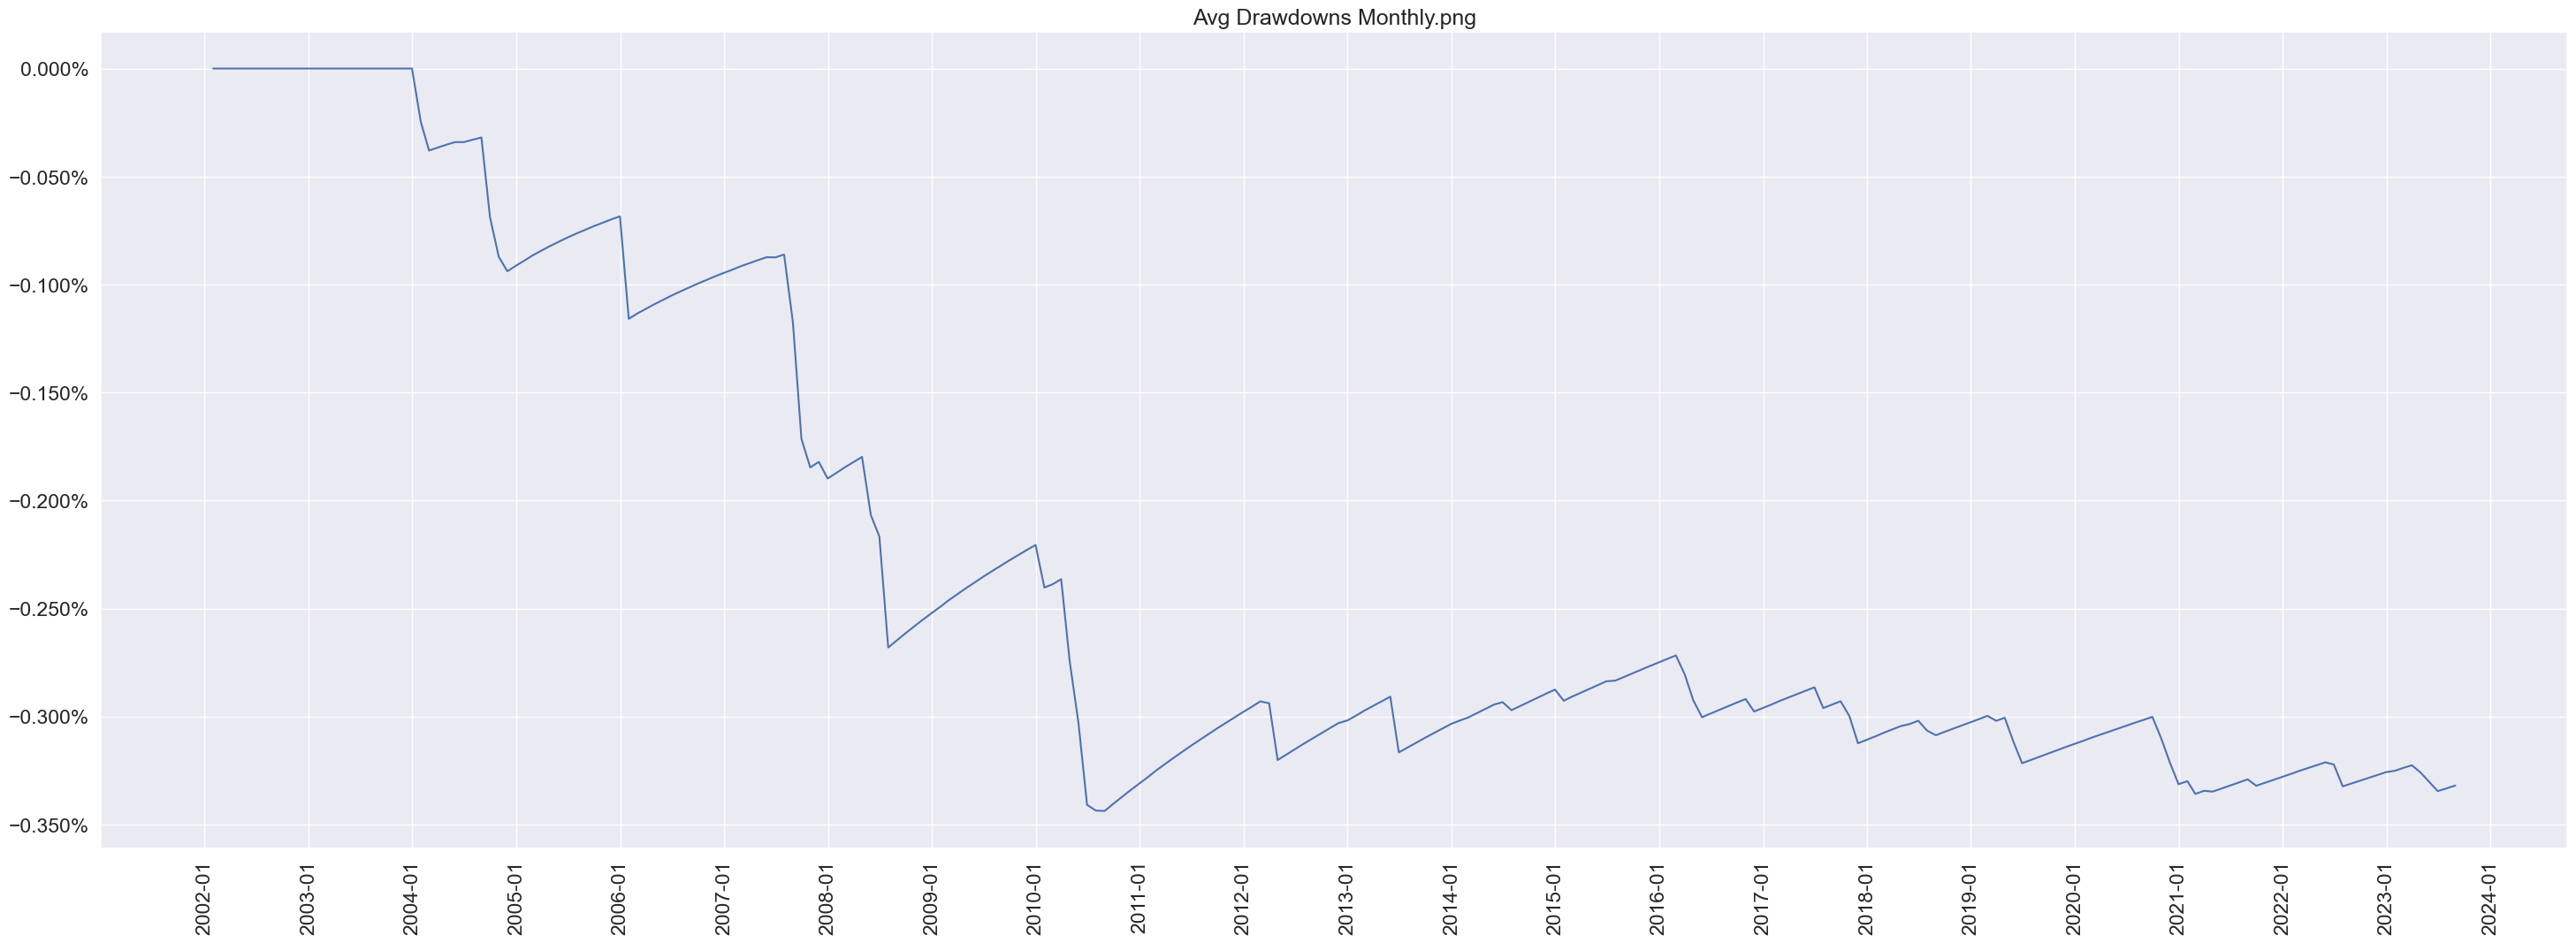

In [70]:
drawdowns_B = Drawdown_g_R({'freq': 'B'})(returns)
drawdowns_M = Drawdown_g_R({'freq': 'M'})(returns)

avg_drawdowns_B = AverageDrawdown_g_R({'freq': 'B'})(returns)
avg_drawdowns_M = AverageDrawdown_g_R({'freq': 'M'})(returns)

import matplotlib.dates as mdates
import matplotlib.ticker as mtick

def plot_drawdowns(drawdowns, title=None, filename=None):
    # plot the drawdowns with nicely formatted dates on the horizontal axis, dates on the x-axis in the format '%Y-%m-%d' tilted at 90 degrees, and the y-axis in percentage format
    if title is None:
        title = 'Drawdowns'
        
    sns.set_style('whitegrid')
    sns.set_context('talk')
    sns.set_palette('dark')
    sns.set(font_scale=1.5)
    plt.figure(figsize=(36, 12))
    plt.plot(drawdowns)
    plt.title(title)
    
    # add vertical and horizontal gridlines
    plt.grid(True, axis='both', which='both')
    
    
    # format the x-axis
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    
    # format the y-axis
    plt.gca().yaxis.set_major_formatter(mtick.PercentFormatter(1.0))
    plt.xticks(rotation=90)
    
    plt.show()
    
    # if filename is not None, save the plot to the filename as an HTML file
    if filename is not None:
        plt.savefig(filename, bbox_inches='tight')
        
# plot the same values as above but using plotly rather than matplotlib
import plotly.graph_objects as go

        
    
plot_drawdowns(drawdowns_B, 'Drawdowns Daily','drawdowns_B.png')
plot_drawdowns(drawdowns_M, 'Drawdowns Monthly.png')
plot_drawdowns(avg_drawdowns_B, 'Avg Drawdowns Daily.png')
plot_drawdowns(avg_drawdowns_M, 'Avg Drawdowns Monthly.png')


In [71]:
# display the 5 longest periods of continuous drawdowns
longest_drawdown_periods_B = LongestDrawdownPeriods_g_R({'freq': 'B', 'num_periods': 5})(returns)
longest_drawdown_periods_M = LongestDrawdownPeriods_g_R({'freq': 'M', 'num_periods': 5})(returns)

print(longest_drawdown_periods_B)
print(longest_drawdown_periods_M)

        GETT                                                   
  start_date   end_date   length max_drawdown max_drawdown_date
1 2007-07-10 2007-12-26 169 days    -0.090657        2007-09-18
2 2019-02-11 2019-07-29 168 days    -0.048865        2019-03-11
3 2010-04-14 2010-09-10 149 days    -0.109595        2010-05-07
4 2016-02-12 2016-06-21 130 days    -0.056979        2016-05-17
5 2008-04-21 2008-08-20 121 days    -0.063555        2008-07-25
        GETT                                                   
  start_date   end_date   length max_drawdown max_drawdown_date
1 2010-04-30 2010-08-31 123 days    -0.041508        2010-06-30
2 2023-04-30 2023-06-30  61 days    -0.014705        2023-05-31
3 2004-09-30 2004-11-30  61 days    -0.012453        2004-09-30
4 2020-10-31 2020-12-31  61 days    -0.028139        2020-11-30
5 2007-08-31 2007-10-31  61 days    -0.038364        2007-09-30


In [73]:
# save the original returns, the daily drawdowns and the monthly drawdowns, and the longest drawdown periods in separate sheet of an XLS file 
with pd.ExcelWriter('GETT_Portfolio_Returns_Analysis.xlsx') as writer:
    returns.to_excel(writer, sheet_name='Returns')
    
    drawdowns_B.to_excel(writer, sheet_name='Drawdowns Daily')
    drawdowns_M.to_excel(writer, sheet_name='Drawdowns Monthly')

    longest_drawdown_periods_B.to_excel(writer, sheet_name='Drawdown Durations Daily')
    longest_drawdown_periods_M.to_excel(writer, sheet_name='Drawdown Durations Monthly')